In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from collections import Counter

### Load the data

In [2]:
data = pd.read_json('train.json')
data.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


### Basic information of cuisines and ingredients

In [3]:
# the list of cuisines
NCuisine = data['cuisine'].nunique()
cuisineList = data['cuisine'].unique()

In [4]:
# the list of ingredients
ingredientBag = [ingredient for i in range(data.shape[0]) for ingredient in data.loc[i,'ingredients']]
ingredientList = sorted(list(set(ingredientBag)))

### Preprocessing

#### Create a binary matrix indicating whether or not an ingredient is in a recipe

In [5]:
# get the list of ingredients
ingredientList = sorted(list(set([ingredient for i in range(data.shape[0]) for ingredient in data.loc[i,'ingredients']])))
# the mapping between ingredient and its index
ingredient2index = dict(zip(ingredientList, range(len(ingredientList))))
# create a binary matrix indicating whether or not an ingredient is in a recipe
binaryIngredientsMat = np.zeros((data.shape[0], len(ingredientList)))
for iRecipe in range(data.shape[0]):
    binaryIngredientsMat[iRecipe, [ingredient2index[ingredient] for ingredient in data.loc[iRecipe, 'ingredients']]] = 1
dataBinaryIngredients = pd.DataFrame(binaryIngredientsMat, columns=ingredientList)
dataBinaryIngredients.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### TF-IDF

In [6]:
# extract the value of the matrix to a numpy array - to speed up calculation
X = dataBinaryIngredients.values
# term frequency
TF = X/np.sum(X,axis=1)[:,np.newaxis]
# inverse document frequency: 1/log(proportion of recipes that have this ingredient)
IDF = np.log(dataBinaryIngredients.shape[0]/X.sum(axis=0)[np.newaxis,:])
# TF-IDF = TF*IDF, and create dataframe
TFIDF = pd.DataFrame(TF*IDF, index=dataBinaryIngredients.index, columns=dataBinaryIngredients.columns)

In [7]:
TFIDF.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
'''
Lili Data processing for TFIDF
'''

from sklearn.preprocessing import StandardScaler
import copy as cp

df = pd.read_pickle('tf_idf.pkl')
data = pd.read_json('train.json')

ingredientList = sorted(list(set([ingredient for i in range(data.shape[0]) for ingredient in data.loc[i,'ingredients']])))
df_sd = cp.deepcopy(df)
df_sd = StandardScaler().fit_transform(df)
df_sd = pd.DataFrame(df_sd, columns=ingredientList)
type(df_sd)
df_sd.head()


,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,-0.015741,-0.014184,-0.008527,-0.006397,-0.006922,-0.008188,-0.008553,-0.009919,-0.00691,-0.016648,...,-0.06612,-0.010746,-0.008288,-0.00697,-0.015419,-0.019113,-0.014451,-0.024915,-0.139033,-0.007091
1,-0.015741,-0.014184,-0.008527,-0.006397,-0.006922,-0.008188,-0.008553,-0.009919,-0.00691,-0.016648,...,-0.06612,-0.010746,-0.008288,-0.00697,-0.015419,-0.019113,-0.014451,-0.024915,-0.139033,-0.007091
2,-0.015741,-0.014184,-0.008527,-0.006397,-0.006922,-0.008188,-0.008553,-0.009919,-0.00691,-0.016648,...,-0.06612,-0.010746,-0.008288,-0.00697,-0.015419,-0.019113,-0.014451,-0.024915,-0.139033,-0.007091
3,-0.015741,-0.014184,-0.008527,-0.006397,-0.006922,-0.008188,-0.008553,-0.009919,-0.00691,-0.016648,...,-0.06612,-0.010746,-0.008288,-0.00697,-0.015419,-0.019113,-0.014451,-0.024915,-0.139033,-0.007091
4,-0.015741,-0.014184,-0.008527,-0.006397,-0.006922,-0.008188,-0.008553,-0.009919,-0.00691,-0.016648,...,-0.06612,-0.010746,-0.008288,-0.00697,-0.015419,-0.019113,-0.014451,-0.024915,-0.139033,-0.007091


### PCA

In [16]:
NComponents = 20

#### using dataBinaryIngredients

In [9]:
X = dataBinaryIngredients
pca_BOW = PCA(n_components=NComponents)
X_r_BOW = pca_BOW.fit(X).transform(X)

In [10]:
# Percentage of variance explained for each components
print('explained variance ratio: %s' % str(pca_BOW.explained_variance_ratio_))
print('explained variance ratio (cumulative): %s' % str(np.cumsum(pca_BOW.explained_variance_ratio_)))

explained variance ratio: [0.02964557 0.02572667 0.02098597 0.01678056 0.01508185 0.0144523
 0.01304761 0.01260552 0.01171041 0.01061699 0.00992276 0.0094496
 0.00873753 0.00834015 0.00817579 0.00750383 0.00724467 0.00685135
 0.00659698 0.00629409]
explained variance ratio (cumulative): [0.02964557 0.05537224 0.07635821 0.09313877 0.10822063 0.12267293
 0.13572054 0.14832606 0.16003647 0.17065346 0.18057622 0.19002582
 0.19876335 0.2071035  0.21527928 0.22278311 0.23002778 0.23687913
 0.2434761  0.24977019]


In [12]:
PCs_BOW = pca_BOW.components_
for i in range(NComponents):
    topIndices = np.where((PCs_BOW[i,:] > np.percentile(PCs_BOW[i,:], 99.9)))[0]
    topIndices = topIndices[np.argsort(-PCs_BOW[i, topIndices])]
    print('Principle component', i+1, ':', X.columns.values[topIndices]) 

Principle component 1 : ['salt' 'onions' 'pepper' 'olive oil' 'garlic' 'water'
 'ground black pepper']
Principle component 2 : ['salt' 'all-purpose flour' 'sugar' 'butter' 'large eggs' 'baking powder'
 'unsalted butter']
Principle component 3 : ['garlic' 'water' 'soy sauce' 'onions' 'sugar' 'vegetable oil'
 'sesame oil']
Principle component 4 : ['garlic cloves' 'water' 'sugar' 'vegetable oil' 'soy sauce' 'salt'
 'carrots']
Principle component 5 : ['olive oil' 'garlic' 'soy sauce' 'salt' 'sugar' 'sesame oil'
 'green onions']
Principle component 6 : ['olive oil' 'water' 'sugar' 'all-purpose flour' 'onions' 'butter'
 'garlic']
Principle component 7 : ['garlic cloves' 'ground black pepper' 'vegetable oil' 'sugar' 'onions'
 'all-purpose flour' 'soy sauce']
Principle component 8 : ['ground black pepper' 'water' 'kosher salt' 'garlic'
 'extra-virgin olive oil' 'vegetable oil' 'all-purpose flour']
Principle component 9 : ['butter' 'soy sauce' 'pepper' 'eggs' 'garlic cloves' 'green onions'
 'se

#### project recipes to the first two principle components (PCs)

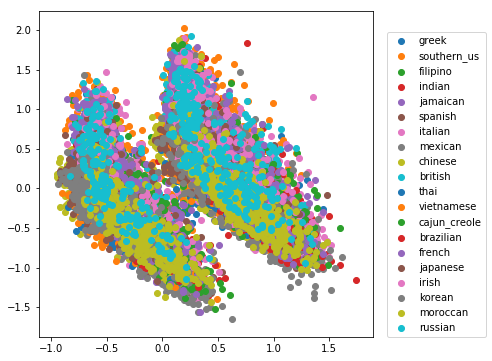

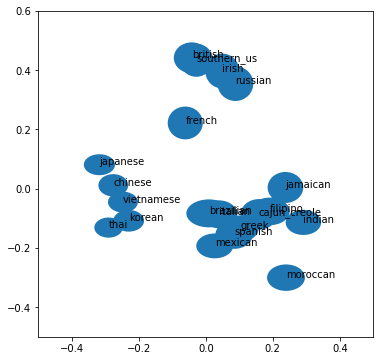

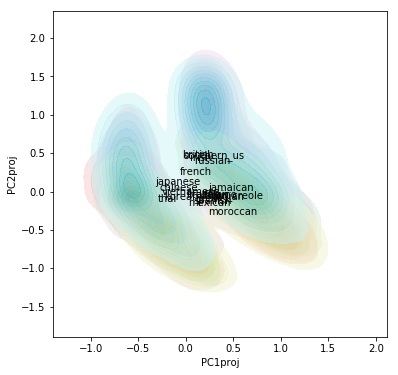

In [26]:
from matplotlib.patches import Ellipse

datawPCA = data.copy()
datawPCA['PC1proj'] = X_r_BOW[:,0]
datawPCA['PC2proj'] = X_r_BOW[:,1]

cuisineCenter = datawPCA.groupby('cuisine').mean()[['PC1proj','PC2proj']]
cuisineSD = datawPCA.groupby('cuisine').std()[['PC1proj','PC2proj']]

# plot all recipes
fig, ax = plt.subplots(figsize=(6,6))
for cuisine in cuisineList:
    ax.scatter(datawPCA.loc[datawPCA['cuisine']==cuisine,'PC1proj'], datawPCA.loc[datawPCA['cuisine']==cuisine,'PC2proj'], label=cuisine)
plt.legend(loc=(1.04,0))

# plot the center (mean) for each cuisine (width/height of the ellipses are 0.1 standard deviation of all recipes in this cuisine)
fig, ax = plt.subplots(figsize=(6,6))
for cuisine in cuisineList:
    ellipse = Ellipse(xy=(cuisineCenter.loc[cuisine,'PC1proj'], cuisineCenter.loc[cuisine,'PC2proj']), width=cuisineSD.loc[cuisine,'PC1proj']/5, height=cuisineSD.loc[cuisine,'PC2proj']/5)
    ax.add_artist(ellipse)
    plt.annotate(cuisine, (cuisineCenter.loc[cuisine,'PC1proj'], cuisineCenter.loc[cuisine,'PC2proj']))
    ax.set(xlim=(-0.5,0.5), ylim=(-0.5,0.6))

# # density plot doesn't seem to work
# fig, ax = plt.subplots(figsize=(6,6))
# for cuisine in cuisineList:
#     sns.kdeplot(datawPCA.loc[datawPCA['cuisine']==cuisine,'PC1proj'], datawPCA.loc[datawPCA['cuisine']==cuisine,'PC2proj'], shade=True, ax=ax, alpha=0.5, shade_lowest=False)
#     plt.annotate(cuisine, (cuisineCenter.loc[cuisine,'PC1proj'], cuisineCenter.loc[cuisine,'PC2proj']))

#### using TF-IDF

In [21]:
#X = TFIDF
X= df_sd
pca_TFIDF = PCA(n_components=NComponents)
X_r_TFIDF = pca_TFIDF.fit(X).transform(X)

In [22]:
# Percentage of variance explained for each components
print('explained variance ratio: %s' % str(pca_TFIDF.explained_variance_ratio_))
print('explained variance ratio (cumulative): %s' % str(np.cumsum(pca_TFIDF.explained_variance_ratio_)))

explained variance ratio: [0.00079167 0.0007487  0.00073259 0.00065889 0.0006122  0.0005564
 0.00053769 0.00053246 0.00052076 0.00051498 0.00050645 0.00046824
 0.00046138 0.00045665 0.00045114 0.00044658 0.00044119 0.00043513
 0.00043183 0.0004272 ]
explained variance ratio (cumulative): [0.00079167 0.00154038 0.00227297 0.00293186 0.00354406 0.00410046
 0.00463815 0.00517061 0.00569137 0.00620635 0.0067128  0.00718104
 0.00764242 0.00809906 0.0085502  0.00899679 0.00943798 0.0098731
 0.01030494 0.01073214]


In [23]:
PCs_TFIDF = pca_TFIDF.components_

for i in range(NComponents):
    topIndices = np.where((PCs_TFIDF[i,:] > np.percentile(PCs_TFIDF[i,:], 99.9)))[0]
    topIndices = topIndices[np.argsort(-PCs_TFIDF[i, topIndices])]
    print('Principle component', i+1, ':', X.columns.values[topIndices])

Principle component 1 : ['buckwheat honey' 'garbanzo bean flour' 'gluten-free oat'
 'psyllium husks' 'teff' 'flaxseed' 'millet']
Principle component 2 : ['soy sauce' 'sesame oil' 'ginger' 'fish sauce' 'scallions' 'fresh ginger'
 'garlic']
Principle component 3 : ['olive oil' 'onions' 'diced tomatoes' 'tomatoes' 'dried oregano'
 'garlic cloves' 'salsa']
Principle component 4 : ['garam masala' 'ground turmeric' 'cumin seed' 'coriander powder'
 'green chilies' 'garlic paste' 'red chili powder']
Principle component 5 : ['salsa' 'sour cream' 'flour tortillas' 'shredded cheddar cheese'
 'black beans' 'corn tortillas' 'refried beans']
Principle component 6 : ['Hawaiian salt' 'raw buckwheat groats' 'sliced mango' 'aÃ§ai'
 'chia seeds' 'cacao nibs' 'hemp seeds']
Principle component 7 : ['Pompeian Canola Oil and Extra Virgin Olive Oil'
 'Gourmet Garden garlic paste' 'Johnsonville Andouille'
 'Gourmet Garden Oregano' 'Gourmet Garden Parsley'
 'Red GoldÂ® diced tomatoes' 'Tuttorosso Diced Tomatoes

#### project recipes to the first two principle components (PCs)

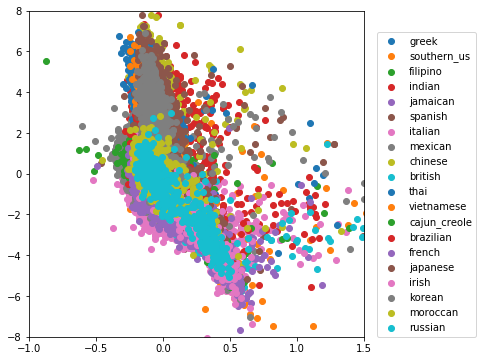

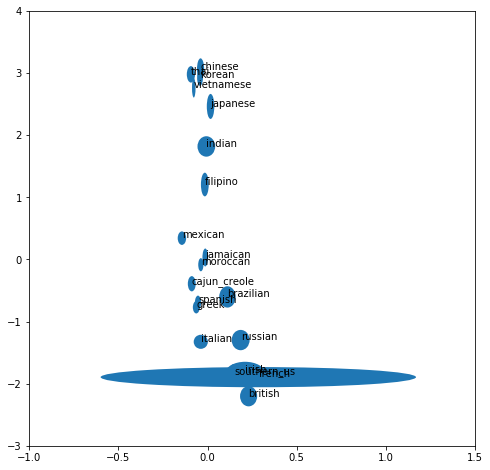

In [33]:
from matplotlib.patches import Ellipse

datawPCA = data.copy()
datawPCA['PC1proj'] = X_r_TFIDF[:,0]
datawPCA['PC2proj'] = X_r_TFIDF[:,1]

cuisineCenter = datawPCA.groupby('cuisine').mean()[['PC1proj','PC2proj']]
cuisineSD = datawPCA.groupby('cuisine').std()[['PC1proj','PC2proj']]

# plot all recipes
fig, ax = plt.subplots(figsize=(6,6))
for cuisine in cuisineList:
    ax.scatter(datawPCA.loc[datawPCA['cuisine']==cuisine,'PC1proj'], datawPCA.loc[datawPCA['cuisine']==cuisine,'PC2proj'], label=cuisine)
plt.legend(loc=(1.04,0))
ax.set(xlim=(-1,1.5), ylim=(-8,8))
    
# plot the center (mean) for each cuisine (width/height of the ellipses are 0.1 standard deviation of all recipes in this cuisine)
fig, ax = plt.subplots(figsize=(8,8))
for cuisine in cuisineList:
    ellipse = Ellipse(xy=(cuisineCenter.loc[cuisine,'PC1proj'], cuisineCenter.loc[cuisine,'PC2proj']), width=cuisineSD.loc[cuisine,'PC1proj']/5, height=cuisineSD.loc[cuisine,'PC2proj']/5)
    ax.add_artist(ellipse)
    plt.annotate(cuisine, (cuisineCenter.loc[cuisine,'PC1proj'], cuisineCenter.loc[cuisine,'PC2proj']))
    ax.set(xlim=(-1,1.5), ylim=(-3,4))

# # density plot doesn't seem to work
# for cuisine in cuisineList:
#     sns.kdeplot(datawPCA.loc[datawPCA['cuisine']==cuisine,'PC1proj'], datawPCA.loc[datawPCA['cuisine']==cuisine,'PC2proj'], shade=True, ax=ax, alpha=0.5, shade_lowest=False)
#     plt.annotate(cuisine, (cuisineCenter.loc[cuisine,'PC1proj'], cuisineCenter.loc[cuisine,'PC2proj']))
#     ax.set(xlim=(-0.3,0.3), ylim=(-0.3,0.3))